<h1> DATA 512 Human-Centered Data Science 
<h2> A2 : Bias in data

The goal of this assignment is to identify what, if any, sources of bias that may exist in a corpus of human-annotated data, and to develop testable hypotheses about how these biases might impact the behavior of machine learning models trained on the data, when those models are used for research purposes or to power data-driven applications. 

The corpus that we will use is the Wikipedia Talk corpus that consists of three datasets. Each dataset contains thousands of online discussion posts made by Wikipedia editors who were discussing how to write and edit Wikipedia articles. Crowdworkers labelled these posts for three kinds of hostile speech: **toxicity**, **aggression**, and **personal attacks**. Many posts in each dataset were labelled by multiple crowdworkers for each type of hostile speech, to improve accuracy.

For this assignment, we will performing a set of analysis on the following sets:
* Aggression
* Hostility

### Importing the packages required for data collection, preprocessing and visualization

Importing the standard packages such as pandas, numpy and matplotlib as well as urllib

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

### Assigning the endpoint URLs for the set of *aggression* and *toxicity* files

Each set has three files, namely annotated comments, annotations and worker demographics

In [98]:
aggression_comments_url = 'https://ndownloader.figshare.com/files/7038038' 
aggression_annotations_url = 'https://ndownloader.figshare.com/files/7394506' 
aggression_demographics_url = 'https://ndownloader.figshare.com/files/7640644'

toxicity_comments_url = 'https://ndownloader.figshare.com/files/7394539' 
toxicity_annotations_url = 'https://ndownloader.figshare.com/files/7394542' 
toxicity_demographics_url = 'https://ndownloader.figshare.com/files/7640581'

### Creating a function to download the set of files for aggression and toxicity datasets

Given the file links from the figshare downloader site and the filenames, the below function downloads the contents to the repository

In [99]:
def download_file(url, fname):
    """
    Input:
    url : the download link from figshare with a file number for each dataset
    fname: the filename with the .tsv extension (tab seperated)
    Ouput:
    Downloads the corresponding file from the link
    """
    urllib.request.urlretrieve(url, fname)

#Aggression
download_file(aggression_comments_url, 'aggression_annotated_comments.tsv')
download_file(aggression_annotations_url, 'aggression_annotations.tsv')
download_file(aggression_demographics_url, 'aggression_worker_demographics.tsv')

#Toxicity
download_file(toxicity_comments_url, 'toxicity_annotated_comments.tsv')
download_file(toxicity_annotations_url, 'toxicity_annotations.tsv')
download_file(toxicity_demographics_url, 'toxicity_worker_demographics.tsv')

### Loading each downloaded file as a pandas dataframe

In [100]:
aggression_comments = pd.read_csv('aggression_annotated_comments.tsv', sep = '\t')
aggression_annotations = pd.read_csv('aggression_annotations.tsv',  sep = '\t')
aggression_demographics = pd.read_csv('aggression_worker_demographics.tsv',  sep = '\t')

toxicity_comments = pd.read_csv('toxicity_annotated_comments.tsv', sep = '\t')
toxicity_annotations = pd.read_csv('toxicity_annotations.tsv',  sep = '\t')
toxicity_demographics = pd.read_csv('toxicity_worker_demographics.tsv',  sep = '\t')

## Step 1: Select and perform analysis

For the assignment, we will be interested in analyzing both aggression and toxicity datasets to answer the following research questions that helps us to understand potential sources of bias, if any
 
1) Is there any unintended bias in the training data with respect to the labelling and distribution of identity terms in the comments? 
* The idea behind this research question is the increasing use of toxic comments and hate speeches across social media and online discussion forums that often contain identity terms based on one's race, religion, gender etc. in a negative connotation targeted against someone, making it difficult to use these terms based on their literal meaning and also to improve the societal awareness. A bias here might result in machine learning models flagging comments with these identity words as a hostile speech which might have adverse implications.

2) How consistent are the labelling behaviours between annotation workers across gender, age and education? 
* The idea behind this question is to understand the distribution of workers based on their gender, age, education etc and how they are related to thier labelling behavior of hostile comments. A skew in the distribution towards one particular profile might result in a biased ML model that is trained.

## 1a. Functions to process, analyze and visualize the two sets of hostile data

### Create master data and do train, dev and test splits

The function merges the annotations, comments and demographics data to create a master dataset and splits the master data into train, dev and test dataframes

In [101]:
def data_processing(df_comments,df_annotations,df_demographics):
    """
    Input:
    df_comments    : dataset that has the comments along with their corresponding revision id and the kind of split
    df_annotations : dataset that has the set of worker IDs and their corresponding aggression/toxicity output label 
                     and score for each revision ID
    df_demographics: dataset that has the demographic profile of each worker ID including gender, age group and education
    
    Output:
    Merges the above three data, replaces system commands such as newline and tab tokens and splits the data
    """
    df_base = df_comments.merge(df_annotations,on='rev_id').merge(df_demographics,on='worker_id',how='left')
    
    df_base_trn  = df_base[df_base.split=='train']
    df_base_dev  = df_base[df_base.split=='dev']
    df_base_test = df_base[df_base.split=='test']
    
    return df_base_trn, df_base_dev, df_base_test

### Calculate the mean ouput rating (0 to 1) per comment

Any comment that has a mean aggression/toxicity rating of more than 0.5 (based on 10 workers) will be labelled as aggressive/toxic through this function and will serve as a unit of analysis for the rest of this assignment

In [102]:
def mean_rating_per_comment_trn (df_base_trn,rating_flag):
    """
    Input:
    df_base_trn : Master dataset that has comments, annotations, output labels and the demographic profile of workers
    rating_flag (str) : Output label ('Aggression' or 'Toxicity')
    
    Output:
    Creates mean output rating per comment for the overall dataset and a second dataset with only comments with mean rating >0.5
    """
    df_trn_ovrl_smry = df_base_trn.groupby(['rev_id','comment','split'],as_index=False).agg({f'{rating_flag}':'mean'})
    df_trn_flag_smry = df_trn_ovrl_smry[df_trn_ovrl_smry[f'{rating_flag}']>0.5]

    return df_trn_ovrl_smry, df_trn_flag_smry

### Calculate the frequency and % appearance of commonly used identity terms

The following function calculates the labelling distribution of commonly used identity terms based on gender, sexual orientation, religion and race. The following identity terms are considered
* gay
* lesbian
* homosexual
* heterosexual
* transgender
* queer
* muslim
* islam
* atheist
* jew
* black
* white

It creates the following metrics
* term_ratio_hostile_flag : % of a particular identity term among all terms found in comments labelled hostile
* term_ratio_overall      : % of a particular identity term among all terms found in comments in the entire training data
* term_freq_hostile_flag  : Number of occurences of a particular identity term in comments labelled hostile
* term_freq_overall       : Number of occurenes of a particular identity term in the entire training data
* term_hostile_flag_ratio : % of comments with a particular identity term that are labelled hostile

In [103]:
def identity_term_ratios(df_trn,df_flg_trn,hostile_flag):
    """
    Input:
    df_trn       : Training dataset that has comments, annotations, output labels and the demographic profile of workers
    hostile_flag (str) : 'Aggressive' or 'toxic'
    
    Output:
    Calculates the following metrics:
    term_ratio_hostile_flag : % of a particular identity term among all terms found in comments labelled hostile
    term_ratio_overall      : % of a particular identity term among all terms found in comments in the entire training data
    term_freq_hostile_flag  : Number of occurences of a particular identity term in comments labelled hostile
    term_freq_overall       : Number of occurenes of a particular identity term in the entire training data
    term_hostile_flag_ratio : % of comments with a particular identity term that are labelled hostile
    """
    df = []
    identity_terms = ['gay','lesbian','homosexual','heterosexual','transgender','queer',
                      'muslim','islam','atheist','jew','black','white']
    
    for term in identity_terms:
        term_freq_flagged = df_flg_trn[(df_flg_trn.comment.str.contains(term,case=False))].shape[0]

        term_freq_overall = df_trn[df_trn.comment.str.contains(term,case=False)].shape[0]

        term_ratio_flagged = df_flg_trn[(df_flg_trn.comment.str.contains(term,case=False))].shape[0] / df_flg_trn.shape[0]

        term_ratio_overall = df_trn[(df_trn.comment.str.contains(term,case=False))].shape[0] / df_trn.shape[0]

        df.append({'identity' : term,
                 f'term_ratio_{hostile_flag}' : round(term_ratio_flagged*100,2),
                 'term_ratio_overall' : round(term_ratio_overall*100,2),
                 f'term_freq_{hostile_flag}' : term_freq_flagged,
                 'term_freq_overall' : term_freq_overall,
                 f'term_{hostile_flag}_ratio' : round((term_freq_flagged/term_freq_overall)*100,2)
                 })
        out = pd.DataFrame(df)
        out.to_csv(f'identity_term_metrics_{hostile_flag}.csv',index=False)

    return out

### Plot the % of comments with identity terms that are labelled hostile

Given identity terms and the % comments with these terms labelled hostile (aggressive or toxic), the function plots the % values and also adds the overall % of comments that are labelled hostile as a benchmark for comparison

In [104]:
def identity_terms_pct_hostile_plot(df_identity_term_smry,hostile_flag,df_mean_all_comments,df_mean_hostile_comments):
    """
    Input:
    df_identity_term_smry   : summary for each identity term (frequency and %)
    hostile_flag  (str)     : 'aggressive' or 'toxic'
    df_mean_all_comments    : 'mean hostile rating for each comment in the training data'
    df_mean_hostile_comments: 'mean hostile rating for each comment labelled hostile (>0.5)'
    
    Output:
    For each identity term, plots the % of comments with that term that are labelled hostile (mean rating >0.5) 
    and also the overall mean hostile rating
    """
    mean_hostile_pct = round((df_mean_hostile_comments.shape[0]/df_mean_all_comments.shape[0])*100,2)
    
    data = df_identity_term_smry.copy().sort_values([f'term_{hostile_flag}_ratio'],ascending=False,ignore_index=True)
    data.plot(x='identity',y=f'term_{hostile_flag}_ratio',kind='bar',figsize=(15,6),fontsize=12)
    plt.ylabel(f"% of comments labelled as {hostile_flag}",fontsize=12)
    plt.xlabel("Identity group",fontsize=12)
    plt.axhline(y=mean_hostile_pct,linewidth=1, linestyle='--',color='k')
    plt.text(8.5,mean_hostile_pct+1,f"% of all comments \n labelled {hostile_flag}({mean_hostile_pct}%)",fontsize=12)
    plt.title(f"% of comments with identity terms that are labelled as {hostile_flag}",fontsize=14)
    plt.legend('')
    plt.savefig(f'identity_pct_hostile_plot_{hostile_flag}.png',dpi=400);

### Plot the % appearance of identity terms in hostile comments vs all comments

In [105]:
def identity_terms_hostile_vs_all_plot(df_identity_term_smry,hostile_flag):
    """
    Input:
    df_identity_term_smry : summary for each identity term (frequency and %)
    hostile_flag (str)    : 'aggressive' or 'toxic'
    """
    data = df_identity_term_smry.copy()
    data.plot(x='identity', y=[f'term_ratio_{hostile_flag}', 'term_ratio_overall'], kind='bar',figsize=(15,6),fontsize=12)
    plt.ylabel('% of comments',fontsize=12)
    plt.xlabel("Identity term",fontsize=12)
    plt.title(f'% appearence in {hostile_flag} comments vs. % appearance in all comments',fontsize=14)
    plt.legend([f'% appearance in {hostile_flag} comments','% appearance in all comments'],fontsize=12);
    plt.savefig(f'identity_hostile_vs_all_plot_{hostile_flag}.png',dpi=400);

### Calculate the average hostile output rating for each annotation worker

In [106]:
def worker_avg_hostility_rating(df_base_trn,df_demographics,rating_flag):
    """
    Input:
    df_base_trn : training dataset that has comments, annotations, output labels and the demographic profile of workers
    df_demographics : demographic information of each worker
    rating_flag (str) :'aggression' or 'toxicity'
    
    Output:
    Calculates the average hostility rating for each worker and adds this info to the demographic dataset
    """
    df_base_trn_fltr = df_base_trn[df_base_trn['gender'] != 'other']
    worker_avg_rating = df_base_trn_fltr.groupby('worker_id',as_index=False).agg({f'{rating_flag}':'mean'})
    worker_avg_rating = worker_avg_rating.rename(columns={f'{rating_flag}': f'{rating_flag}_mean'})
    df_dmgraph_w_avg_rating = df_demographics.merge(worker_avg_rating,on='worker_id')
    
    return df_dmgraph_w_avg_rating

### Get the counts of workers/annotations and mean hostile rating for a demographic profile

In [107]:
def summary_by_demography(df_base_trn,attribute,rating_flag):
    """
    Input:
    df_base_trn : training dataset that has comments, annotations, output labels and the demographic profile of workers
    attribute (str) : 'gender' or 'age_group' or 'education'
    rating_flag (str) :'aggression' or 'toxicity'
    
    Output:
    Calculates the count of worker IDs, annotations and mean average rating by gender or age or education
    """
    df_base_trn_fltr = df_base_trn[df_base_trn['gender'] != 'other'] 
    df_smry_by_attr = df_base_trn_fltr.groupby([f'{attribute}'],as_index=False).agg({'worker_id':'nunique',
                                                                                    'rev_id':'count',
                                                                                    f'{rating_flag}':'mean'})
    df_smry_by_attr = df_smry_by_attr.rename(columns={'worker_id':'worker_id_count','rev_id':'rev_id_count',
                                                      f'{rating_flag}':f'{rating_flag}_mean'})

    df_smry_by_attr['worker_id_pct']= round((df_smry_by_attr.worker_id_count/df_smry_by_attr.worker_id_count.sum())*100,2)
    df_smry_by_attr['rev_id_pct']= round((df_smry_by_attr.rev_id_count/df_smry_by_attr.rev_id_count.sum())*100,2)

    return df_smry_by_attr

### Plot the % makeup of workers and mean hostile rating by demographic profile

In [108]:
def demography_plot(df_smry_by_attr,df_dmgraph_w_avg_rating,rating_flag,attribute):
    """
    Input:
    df_smry_by_attr : counts and mean rating for each demographic attribute
    df_dmgraph_w_avg_rating : demographic profile of each worker ID along with their mean hostile rating per comment
    rating_flag (str) :'aggression' or 'toxicity'
    attribute (str) : 'gender' or 'age_group' or 'education'
    
    Output:
    Plots the % distribution of workers and annotations and distribution of average ratings by gender or age or education
    """
    fig, axes = plt.subplots(1, 2,figsize=(15,6))
    attribute_summary = df_smry_by_attr.copy()
    attribute_summary.plot(x= f'{attribute}', y=['worker_id_pct', 'rev_id_pct'], kind='bar',ax=axes[0])
    axes[0].set_title(f'distribution of annotators/annotations by {attribute}',fontsize=14)
    axes[0].set_ylabel('% of total',fontsize=12)
    axes[0].set_xlabel(f"{attribute}",fontsize=12)
    axes[0].legend(['Annotation workers','Annotations'],fontsize=12)

    sns.boxplot(x=f'{attribute}', y=f'{rating_flag}_mean', data=df_dmgraph_w_avg_rating,ax=axes[1])
    axes[1].set_title(f'distribution of {rating_flag} labels by {attribute}',fontsize=14)
    axes[1].set_ylabel(f'mean {rating_flag} rating',fontsize=12)
    axes[1].set_xlabel(f"{attribute}",fontsize=12)
    axes[1].legend('')
    plt.savefig(f'demographic_plot_{attribute}_{rating_flag}.png',dpi=400);

## 1b. Analysis on aggrssion data
### Checking the head of comments, annotations and demographics data pertaining to aggression

In [109]:
aggression_comments.head()
aggression_annotations.head()
aggression_demographics.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,True,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,True,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


,rev_id,worker_id,aggression,aggression_score
0,37675,1362,1.0,-1.0
1,37675,2408,0.0,1.0
2,37675,1493,0.0,0.0
3,37675,1439,0.0,0.0
4,37675,170,0.0,0.0


,worker_id,gender,english_first_language,age_group,education
0,833,female,0,45-60,bachelors
1,1072,male,0,30-45,bachelors
2,872,male,0,18-30,hs
3,2116,male,0,30-45,professional
4,453,male,0,30-45,hs


### Creating the train, test and dev data for aggression and checking the head of train

In [110]:
aggression_base_trn, aggression_base_dev, aggression_base_test = data_processing(aggression_comments,
                                                                                aggression_annotations,
                                                                                aggression_demographics)
aggression_base_trn.head(2)

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,aggression,aggression_score,gender,english_first_language,age_group,education
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train,1362,1.0,-1.0,male,0.0,18-30,masters
1,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train,2408,0.0,1.0,male,1.0,30-45,hs


### Creating a mean aggression rating for each comment and filtering the comments with rating >0.5

In [111]:
aggression_mean_all_cmnt, aggression_mean_aggressive_cmnt = mean_rating_per_comment_trn(aggression_base_trn,'aggression')

### Creating the frequency and % appearance of identity terms in aggressive comments vs all comments

In [112]:
aggression_identity_term_smry = identity_term_ratios(aggression_mean_all_cmnt,aggression_mean_aggressive_cmnt,'aggressive')
aggression_identity_term_smry

,identity,term_ratio_aggressive,term_ratio_overall,term_freq_aggressive,term_freq_overall,term_aggressive_ratio
0,gay,3.49,0.80,308,558,55.20
1,lesbian,0.15,0.07,13,46,28.26
2,homosexual,0.79,0.27,70,185,37.84
3,heterosexual,0.02,0.03,2,19,10.53
4,transgender,0.03,0.03,3,18,16.67
5,queer,0.39,0.08,34,53,64.15
6,muslim,0.52,0.59,46,412,11.17
7,islam,0.56,0.63,49,439,11.16
8,atheist,0.23,0.15,20,106,18.87
9,jew,1.66,1.20,146,834,17.51


The above table lists some metrics that would help us in understanding if there is any bias associated with the chosen identity terms.The list and the subsequent analysis is based on the training data. We will be further exploring these metrics visually below

### Plotting the % of comments containing an identity term that are labelled aggressive

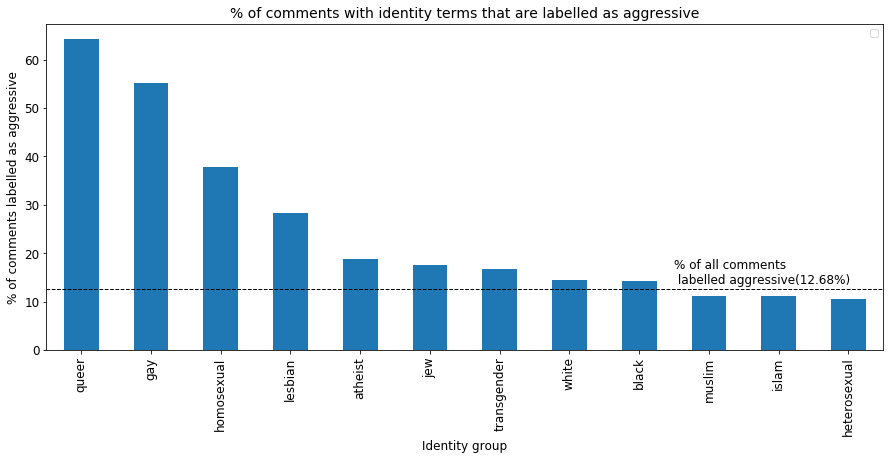

In [113]:
identity_terms_pct_hostile_plot(aggression_identity_term_smry,
                                'aggressive',
                                aggression_mean_all_cmnt,
                                aggression_mean_aggressive_cmnt)

The above plot plots the % of comments that have an identity term in them being lablled as aggressive by a majority of the workers (with mean aggression >0.5). Looking at the plot, it can be seen that comments with the terms 'queer', 'gay' and 'homosexual' have a high perentage of being labelled as aggressive. For ex: Among 558 comments containing the word 'gay', 308 comments (**~55%**) had a mean aggression of > 0.5. On the other hand, the overall % of comments that were labelled as aggressive is **~12.6%**. This indicates an over representation of these identity terms and the trained ML model is likely to flag comments with these terms as aggressive with a very high probability (even when the term 'gay' is used in a positive connotation. for ex: I am proud to be a gay person.

### Plotting the % appearance in aggressive comments vs all comments for each identity term

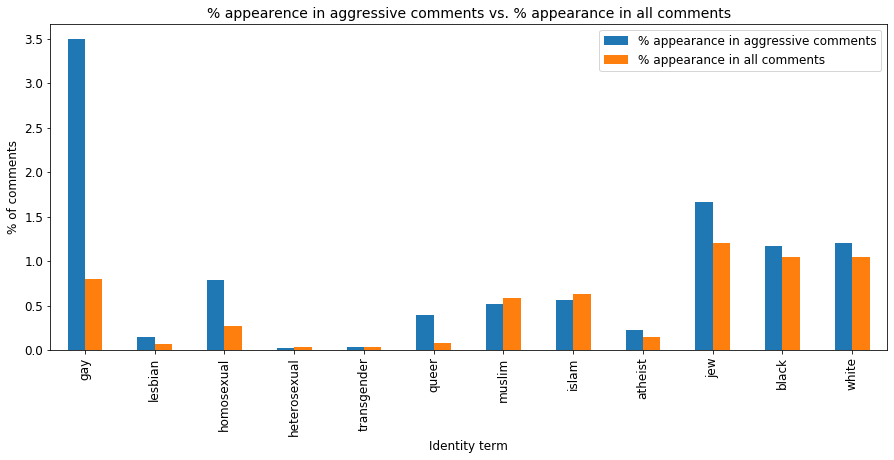

In [114]:
identity_terms_hostile_vs_all_plot(aggression_identity_term_smry,'aggressive')

The above plot plots the % appearance of identity terms in aggressive comments versus % appearance of those terms in all comments in the training data.On observation, it could be seen that among all comments that were labelled aggressive, the identity term 'gay' constituted **3.49%** of such comments. However, looking at the entire training data, comments with the word 'gay' accounts for only **0.8%**. This indicates an unintended bias that overrepresents 'gay' in the aggressive comments. Similarly, the terms *'homosexual'* and *'queer'* also have a high % of aggresive comments that may not be a representative of the population.

### Creating the demographic summaries and checking the head of each summary

In [115]:
aggression_dmgraph_w_avg_rating = worker_avg_hostility_rating(aggression_base_trn,aggression_demographics,'aggression')

aggression_smry_by_gender   = summary_by_demography(aggression_base_trn,'gender','aggression')
aggression_smry_by_age      = summary_by_demography(aggression_base_trn,'age_group','aggression')
aggression_smry_by_education= summary_by_demography(aggression_base_trn,'education','aggression')

aggression_dmgraph_w_avg_rating.head()
aggression_smry_by_gender.head()
aggression_smry_by_age.head()
aggression_smry_by_education.head()

,worker_id,gender,english_first_language,age_group,education,aggression_mean
0,833,female,0,45-60,bachelors,0.164589
1,1072,male,0,30-45,bachelors,0.296875
2,872,male,0,18-30,hs,0.084175
3,2116,male,0,30-45,professional,0.357895
4,453,male,0,30-45,hs,0.138983


,gender,worker_id_count,rev_id_count,aggression_mean,worker_id_pct,rev_id_pct
0,female,838,172849,0.194233,38.33,36.3
1,male,1348,303310,0.171356,61.67,63.7


,age_group,worker_id_count,rev_id_count,aggression_mean,worker_id_pct,rev_id_pct
0,18-30,1046,217610,0.165195,48.63,46.34
1,30-45,831,199182,0.185810,38.63,42.42
2,45-60,217,43243,0.231344,10.09,9.21
3,Over 60,20,4317,0.227936,0.93,0.92
4,Under 18,37,5241,0.125930,1.72,1.12


,education,worker_id_count,rev_id_count,aggression_mean,worker_id_pct,rev_id_pct
0,bachelors,860,191785,0.178601,39.34,40.28
1,doctorate,20,4261,0.190566,0.91,0.89
2,hs,630,132848,0.180183,28.82,27.90
3,masters,385,85743,0.179758,17.61,18.01
4,none,1,56,0.089286,0.05,0.01


### Plotting distribution of % workers/annotations and mean aggression rating by gender

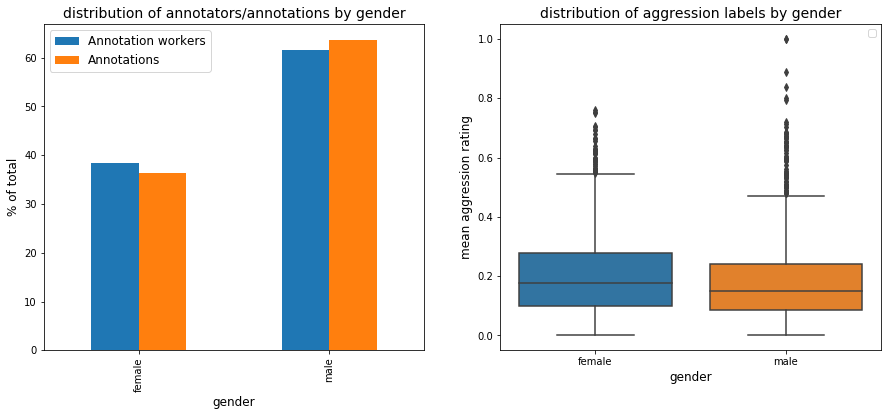

In [116]:
demography_plot(aggression_smry_by_gender,aggression_dmgraph_w_avg_rating,'aggression','gender')

In terms of gender distribution, both the number of workers and the number of annotations are skewed towards male group as they make up 3/5th (~60%) of the training set. This bias might impact an ML model as the labelling behavior of the male group is different as compared to the female group. As observed in the boxplot, male group tends to have a higher tolerance for aggressive comments as their overall mean rating for aggression ($~0.17$) is lower then the female group's mean ($~0.19$). This bias might potentially result in the ML model not flagging certain comments as aggressive.

For the purpose of analysis, since there was only one worker with the gender 'other', only male and female workers are considered.

### Plotting distribution of % workers/annotations and mean aggression rating by age group

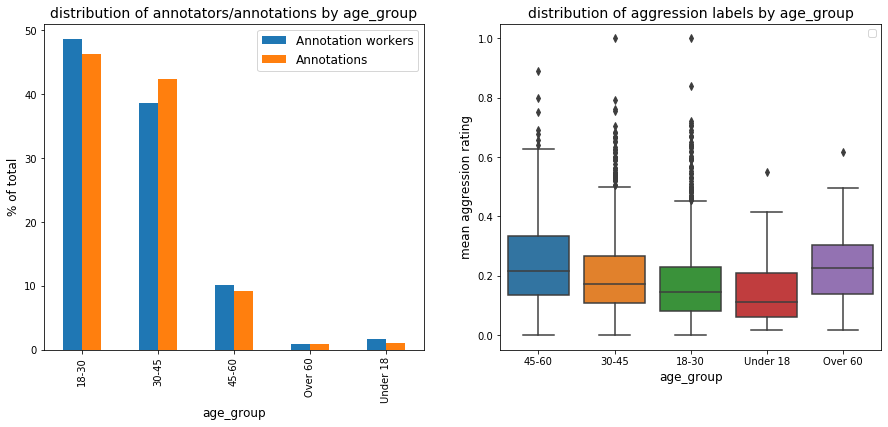

In [117]:
demography_plot(aggression_smry_by_age,aggression_dmgraph_w_avg_rating,'aggression','age_group')

Looking at the age group distribution, the age groups 18-45 account for ~90% of the training group. While this might be a representative of wikipedia editors, it need not necessarily represent the viewer population. This bias once again might impact the performance of the ML model as there is a difference in the labelling behavior of a 20 year old worker compared to a 50 year old worker. Younger annotation workers are more tolerant to aggressive comments and the mean aggression rating increases with the age group.

### Plotting distribution of % workers/annotations and mean aggression rating by education

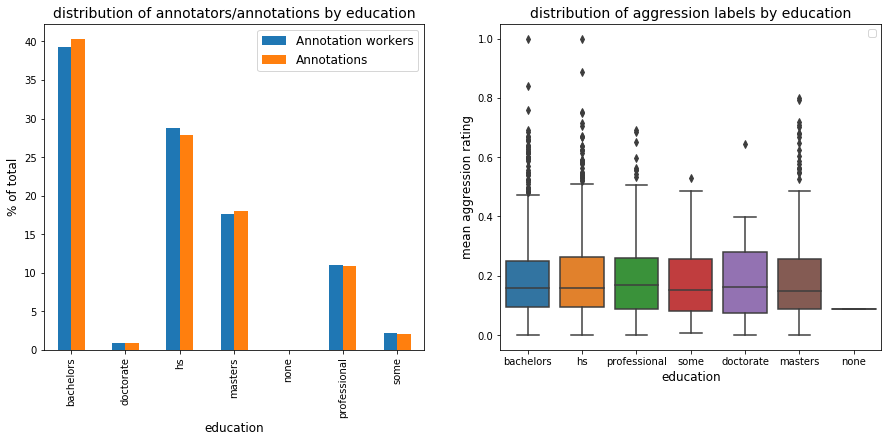

In [118]:
demography_plot(aggression_smry_by_education,aggression_dmgraph_w_avg_rating,'aggression','education')

Lokoing at the education levels of the workers, majority of the crowd has either bachelors degree or a high school education, followed by masters. The labelling behavior on the other hand is quite consistent (mean aggression rating) across the education levels indicating no obvious bias

## 1c. Toxicity analysis
### Checking the head of toxicity datasets

In [119]:
toxicity_comments.head()
toxicity_annotations.head()
toxicity_demographics.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


,worker_id,gender,english_first_language,age_group,education
0,85,female,0,18-30,bachelors
1,1617,female,0,45-60,bachelors
2,1394,female,0,NaN,bachelors
3,311,male,0,30-45,bachelors
4,1980,male,0,45-60,masters


### Creating the base data split into train, test and dev sets after some basic preprocessing

In [120]:
toxicity_base_trn, toxicity_base_dev, toxicity_base_test = data_processing(toxicity_comments,
                                                                                toxicity_annotations,
                                                                                toxicity_demographics)
toxicity_base_trn.head(2)

,rev_id,worker_id,toxicity,toxicity_score,comment,year,logged_in,ns,sample,split,gender,english_first_language,age_group,education
0,2232.0,723,0,0.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,female,0.0,30-45,bachelors
1,2232.0,4000,0,0.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,male,1.0,18-30,hs


### Creating a mean toxicity rating for each comment and filtering the comments with rating >0.5

In [121]:
toxicity_mean_all_cmnt, toxicity_mean_aggressive_cmnt = mean_rating_per_comment_trn(toxicity_base_trn,'toxicity')

### Creating a set of frequency and ratio metrics for each identity term in the toxicity training data

In [122]:
toxicity_identity_term_smry = identity_term_ratios(toxicity_mean_all_cmnt,toxicity_mean_aggressive_cmnt,'toxic')
toxicity_identity_term_smry

,identity,term_ratio_toxic,term_ratio_overall,term_freq_toxic,term_freq_overall,term_toxic_ratio
0,gay,3.80,0.67,351,638,55.02
1,lesbian,0.16,0.05,15,50,30.00
2,homosexual,0.91,0.23,84,216,38.89
3,heterosexual,0.02,0.03,2,27,7.41
4,transgender,0.04,0.03,4,24,16.67
5,queer,0.38,0.06,35,61,57.38
6,muslim,0.56,0.49,52,467,11.13
7,islam,0.48,0.51,44,491,8.96
8,atheist,0.17,0.13,16,121,13.22
9,jew,1.72,0.95,159,913,17.42


### Plotting the % of comments with identity terms that are labelled toxic

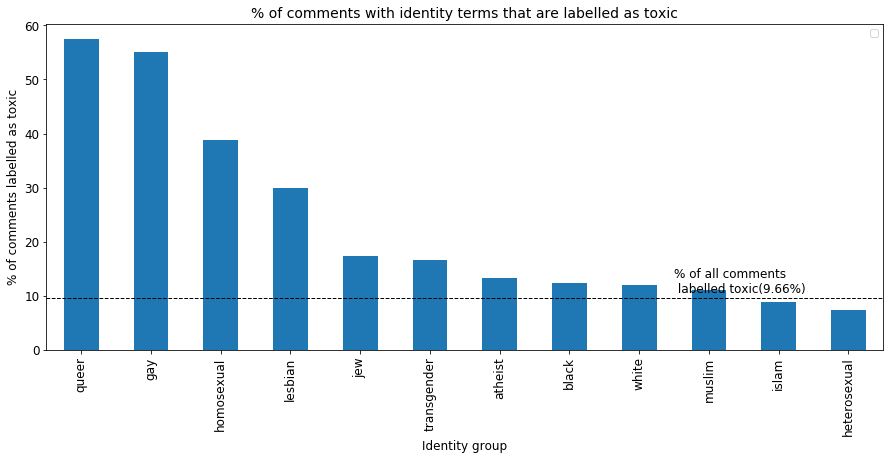

In [123]:
identity_terms_pct_hostile_plot(toxicity_identity_term_smry,'toxic',toxicity_mean_all_cmnt, toxicity_mean_aggressive_cmnt)

Just like aggression, a high % of comments with the words 'queer', 'gay' and 'homosexual' in the training data are labelled as toxic by the workers, which is much higher than the overall average of 9.66%, once again indicating a potential bias for these terms.

### Plotting the % appearance of identity terms in toxic comments vs. all comments

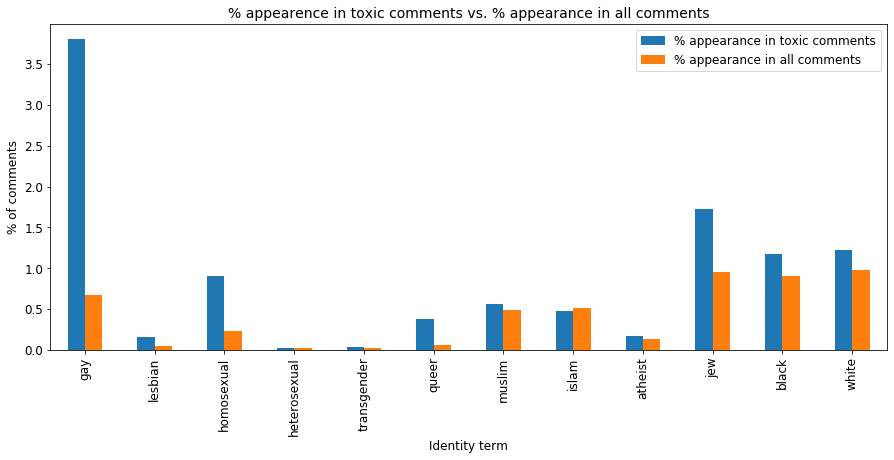

In [124]:
identity_terms_hostile_vs_all_plot(toxicity_identity_term_smry,'toxic')

Like aggression, comments with the word 'gay' account for only 0.67% in the training data, whereas the number shoots up to 3.8% when filtered for toxic comments. One notable difference between toxicity and aggression is observed for the word 'jew' as the representation of 'jew' in the toxic comments is much higher compared to the overall representation and this is a potential bias in the training data

### Calculating the counts and rating averages by gender, age and education

In [125]:
toxicity_dmgraph_w_avg_rating = worker_avg_hostility_rating(toxicity_base_trn,toxicity_demographics,'toxicity')

toxicity_smry_by_gender   = summary_by_demography(toxicity_base_trn,'gender','toxicity')
toxicity_smry_by_age      = summary_by_demography(toxicity_base_trn,'age_group','toxicity')
toxicity_smry_by_education= summary_by_demography(toxicity_base_trn,'education','toxicity')

toxicity_dmgraph_w_avg_rating.head()
toxicity_smry_by_gender.head()
toxicity_smry_by_age.head()
toxicity_smry_by_education.head()

,worker_id,gender,english_first_language,age_group,education,toxicity_mean
0,85,female,0,18-30,bachelors,0.115672
1,1617,female,0,45-60,bachelors,0.098540
2,1394,female,0,NaN,bachelors,0.307692
3,311,male,0,30-45,bachelors,0.184783
4,1980,male,0,45-60,masters,0.174089


,gender,worker_id_count,rev_id_count,toxicity_mean,worker_id_pct,rev_id_pct
0,female,1263,274599,0.157328,35.18,34.01
1,male,2327,532896,0.140279,64.82,65.99


,age_group,worker_id_count,rev_id_count,toxicity_mean,worker_id_pct,rev_id_pct
0,18-30,1862,425128,0.141816,53.00,53.82
1,30-45,1247,280814,0.149494,35.50,35.55
2,45-60,296,61552,0.165405,8.43,7.79
3,Over 60,30,5805,0.154522,0.85,0.73
4,Under 18,78,16567,0.120662,2.22,2.10


,education,worker_id_count,rev_id_count,toxicity_mean,worker_id_pct,rev_id_pct
0,bachelors,1441,323555,0.150336,40.14,40.07
1,doctorate,41,8777,0.133189,1.14,1.09
2,hs,1025,228649,0.142590,28.55,28.32
3,masters,546,123287,0.146958,15.21,15.27
4,none,3,588,0.127551,0.08,0.07


### Plotting distribution of % workers/annotations and mean toxicity rating by gender

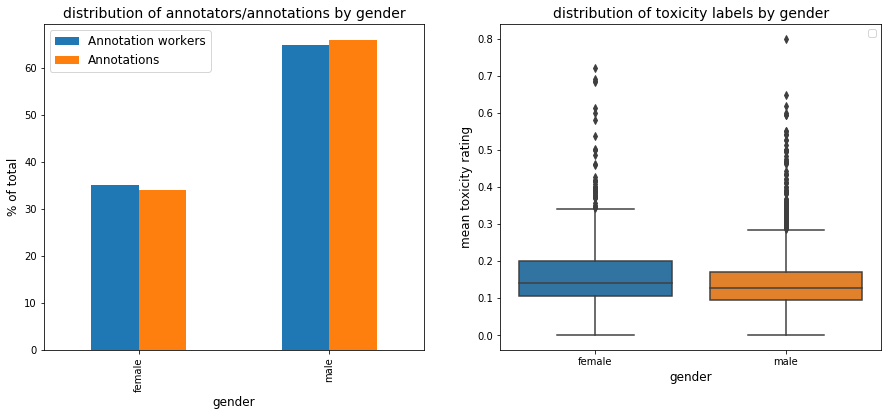

In [126]:
demography_plot(toxicity_smry_by_gender,toxicity_dmgraph_w_avg_rating,'toxicity','gender')

For toxicity, just like aggression, the distribution of workers and annotations are skewed towards male group. However, the difference in the labelling behavior is not quite pronounced as aggression. Female group still has a higher mean toxicity rating (0.157) compared to the male group (0.140)

### Plotting distribution of % workers/annotations and mean toxicity rating by age group

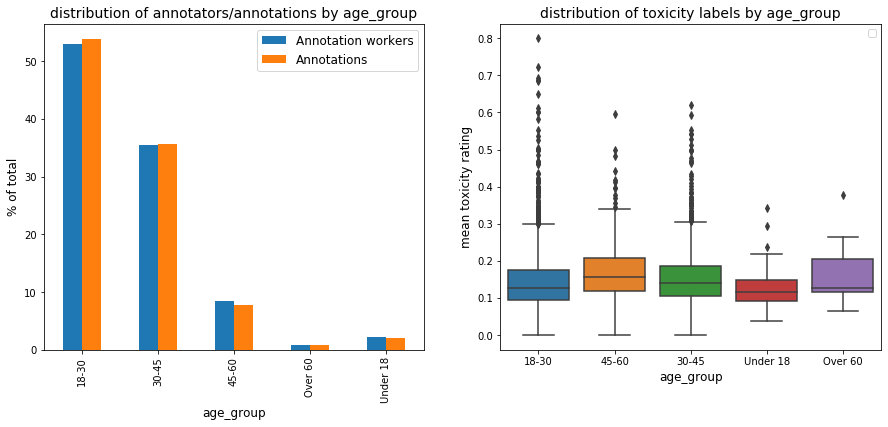

In [127]:
demography_plot(toxicity_smry_by_age,toxicity_dmgraph_w_avg_rating,'toxicity','age_group')

A similar trend is followed in the age group distribution as well for toxicity, as workers in the younger age group have a higher tolerance for labelling toxic comments compared to the workers in the older age groups.

### Plotting distribution of % workers/annotations and mean toxicity rating by education

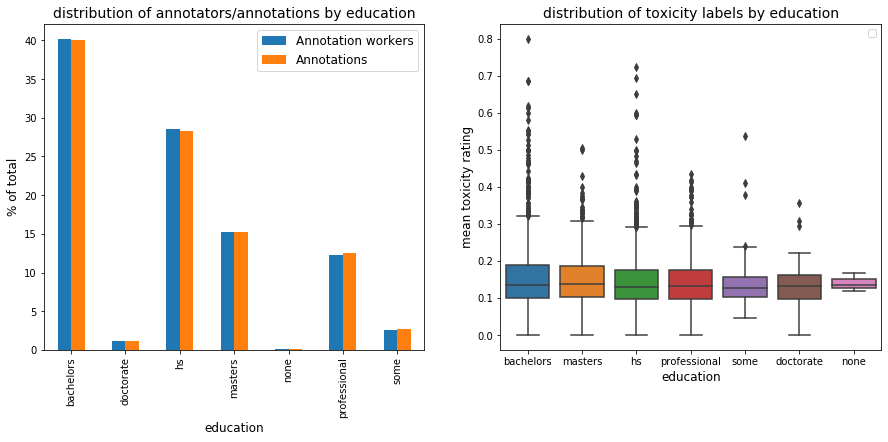

In [128]:
demography_plot(toxicity_smry_by_education,toxicity_dmgraph_w_avg_rating,'toxicity','education')

In terms of education, there is no noticeable difference in the labelling behavior across different education levels

## Bias Analysis observations



1) Is there any unintended bias in the training data with respect to the labelling and distribution of identity terms in the comments? 
* As observed in both aggression and toxicity training data, there is a bias in the representation of identity terms in the hostile comments. Comments with terms such as 'gay', 'homosexual' and 'queer' have a high chance of being labelled as toxic or aggressive by the trained ML model. 
* Also the appearance of such terms in the hostile comments are disproportionately high compared to their overall appearance in the training data. This is observed only in select identity groups and not all terms that we considered for our analysis
* A more balanced representation of identity groups in the training data might help train the ML model more effectively (For example by adding more comments with identity terms that convey a positive emotion)

2) How consistent are the labelling behaviours between annotation workers across gender, age and education? 
* It is observed that the distribution is not balanced across the demographic profiles such as gender, age and education. While female group is under-representated in the training data in both toxicity and aggression, their groups also have a higher average scores for toxic and aggressive comments. Similarly, age group 18-30 account for more than 50% of the training data but have a higher tolerance for both toxicity and aggression. There is no obvious bias observed in the education levels, though the possibility of bias cannot be completely ruled out 

## Step 2: Discuss further implications

1. Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?

 * The Perspective API would work well on comments filter and sliders for organizing comments particularly on topics that are difficult to discuss on platforms like Facebook, Twitter, Reddit and Youtube. I like the fact that the tool allows the readers to control the toxicity score so that the reader can go through some meaningful discussions without having to read some toxic comments. Barring the unintended bias it has on select terms, I still think the model would do a fairly good job of filtering out or organizing the comments for majority of the articles. Given the exponential growth of social networks and as a consequence rise in hate speech and abuse, such an utility tool will be really powerful.

5. What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?

 * Based on the analysis, some of the unintended consequences of using the Perspective API might occur when it is used to analyze sensitive articles such as articles around womens rights or LGBTQ rights. For example, the hot topic application, which predicts the toxicity of an unpublished article might have a higher toxicity score for an article discussing LGBTQ rights, when in reality, it may not necessarily be the case and might afeect the release of the article. Having said that, The API would still work well on 90% of the cases and I would ensure that the models are trained on data with as much minimal bias as possible before using it to moderate or analyze all articles.

6. Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?

 * Based on the analysis done so far, one of the major findings from the training data behind Perspective API is the presence of unintended bias in the representation of identity terms. If I were to improve the models powering the Perspective API, I would try to sample a more balanced training data so that the over representation of terms that are not meant to be toxic/aggressive are nullified to an extent. While this might a change in the sampling strategy (stratified sampling to bring a balance), I believe the data will be a better representation of select terms and would be especially useful when the Perspective API is used to moderate articles revolving around civil rights.